In [1]:
%run init_notebook.py

import os
import torch
import torch.optim as optim
import torchaudio.transforms as T
import time
import torchaudio
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from IPython.display import Audio, display

from src.dataset import NSynth   
from src.models import VAE
from src.utils.models import adjust_shape, compute_magnitude_and_phase
from src.utils.logger import save_training_results
from src.utils.annealing import Annealer
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = r"C:\Users\Articuno\Desktop\TFG-info\data\models\vae.pth"



In [2]:
# STFT transform
sample_rate = 16000
n_fft = 1500
hop_length = 250
win_length = n_fft
stft_transform = T.Spectrogram(
    n_fft=n_fft, win_length=win_length, hop_length=hop_length,
    power=None, onesided=False, center=False
).to(device)
istft_transform = torchaudio.transforms.InverseSpectrogram(
    n_fft=n_fft, win_length=win_length, hop_length=hop_length, onesided=False
).to(device)

# Data loaders
batch_size = 128
train_loader = DataLoader(NSynth('training'), batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(NSynth('validation'), batch_size=batch_size, shuffle=True, pin_memory=True)

# Model setup
input_height = 1500
input_width = 251
input_size = (input_height, input_width)
latent_dim = 200
channels   = [2,16,32,64]
learning_rate = 1e-4

model = VAE(input_size=input_size, latent_dim=latent_dim, channels=channels).to(device)

if os.path.exists(model_path):
    try:
        model.load_state_dict(torch.load(model_path))
        print("Model loaded successfully.")
    except PermissionError as e:
        print(f"PermissionError: {e}. Unable to load the model.")
else:
    print("No saved model found, starting training from scratch.")

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
patience_es = 3

# Training params
num_epochs = 20
warmup_epochs = 8
shape = 'logistic'
baseline = 0.1
disable = False
cyclical = True
annealer = Annealer(total_steps=warmup_epochs, shape=shape, baseline=baseline, disable=disable, cyclical=cyclical)

training_losses, validation_losses = [], []
recon_losses, kl_losses, beta_values = [], [], []

best_val_loss = float('inf')
epochs_no_improve = 0
total_epoch_time = 0.0

print(f"Starting training on {device}...")
for epoch in range(1, num_epochs+1):
    start = time.time()
    model.train()
    running_loss = running_recon = running_kl = 0.0

    # record beta at this epoch
    beta = annealer._slope()
    beta_values.append(beta)

    for waveform, _, _, _ in train_loader:
        waveform = waveform.to(device)
        stft_spec = stft_transform(waveform)
        mag, phase = compute_magnitude_and_phase(stft_spec)
        x = torch.cat([mag, phase], dim=1).to(device)

        optimizer.zero_grad()
        recon_term, kld = model(x)
        kld_annealed = annealer(kld)
        loss = model.loss_function(recon_term, kld_annealed)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        running_recon += -recon_term.sum().item()
        running_kl    += kld.sum().item()

   
    avg_train_loss = running_loss / len(train_loader.dataset)
    recon_losses.append(running_recon / len(train_loader.dataset))
    kl_losses.append(running_kl / len(train_loader.dataset))

    # validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for waveform, _, _, _ in valid_loader:
            waveform = waveform.to(device)
            stft_spec = stft_transform(waveform)
            mag, phase = compute_magnitude_and_phase(stft_spec)
            x = torch.cat([mag, phase], dim=1).to(device)

            recon_term, kld = model(x)
            kld_annealed = annealer(kld)
            loss = model.loss_function(recon_term, kld_annealed)
            running_val_loss += loss.item() * x.size(0)

    

    avg_val_loss = running_val_loss / len(valid_loader.dataset)
    training_losses.append(avg_train_loss)
    validation_losses.append(avg_val_loss)

    # step annealer and scheduler
    annealer.step()
    scheduler.step(avg_val_loss)

    epoch_time = time.time() - start
    total_epoch_time += epoch_time

    print(f"Epoch {epoch}: train_loss={avg_train_loss:.3f}, "
          f"valid_loss={avg_val_loss:.3f}, β={beta:.3f}, time={epoch_time:.1f}s")

    # early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience_es:
            print(f"Stopping early at epoch {epoch}")
            break

print("Training complete.")

No saved model found, starting training from scratch.
Starting training on cuda...
Epoch 1: train_loss=2170214.112, valid_loss=1417193.279, β=0.116, time=670.0s
Epoch 2: train_loss=1260703.778, valid_loss=1208015.369, β=0.143, time=923.5s
Epoch 3: train_loss=1106567.739, valid_loss=1121049.898, β=0.207, time=1100.5s
Epoch 4: train_loss=1016485.514, valid_loss=1054837.501, β=0.342, time=628.7s
Epoch 5: train_loss=939829.720, valid_loss=1006052.449, β=0.550, time=625.0s
Epoch 6: train_loss=948186.909, valid_loss=986504.491, β=0.758, time=657.2s
Epoch 7: train_loss=1126781.014, valid_loss=993515.237, β=0.893, time=637.5s
Epoch 8: train_loss=876586.548, valid_loss=974062.850, β=0.957, time=514.6s
Epoch 9: train_loss=836350.264, valid_loss=947554.900, β=0.116, time=622.4s
Epoch 10: train_loss=819862.402, valid_loss=942967.018, β=0.143, time=624.8s
Epoch 11: train_loss=805229.695, valid_loss=934758.622, β=0.207, time=633.6s
Epoch 12: train_loss=791192.810, valid_loss=931996.651, β=0.342, tim

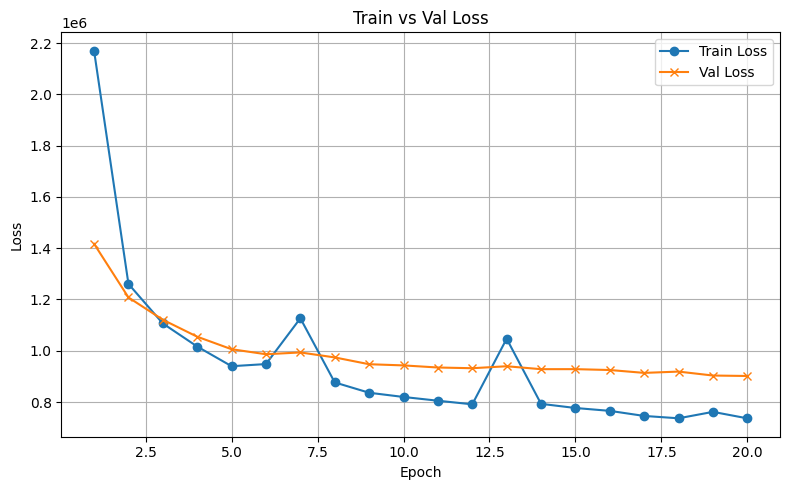

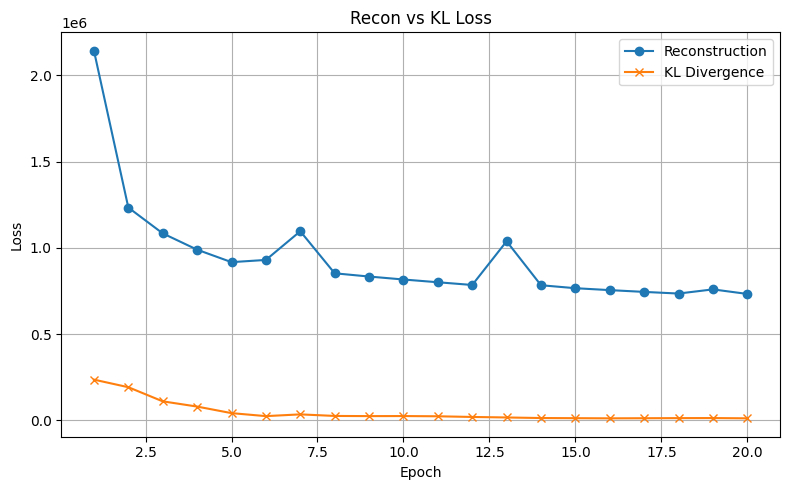

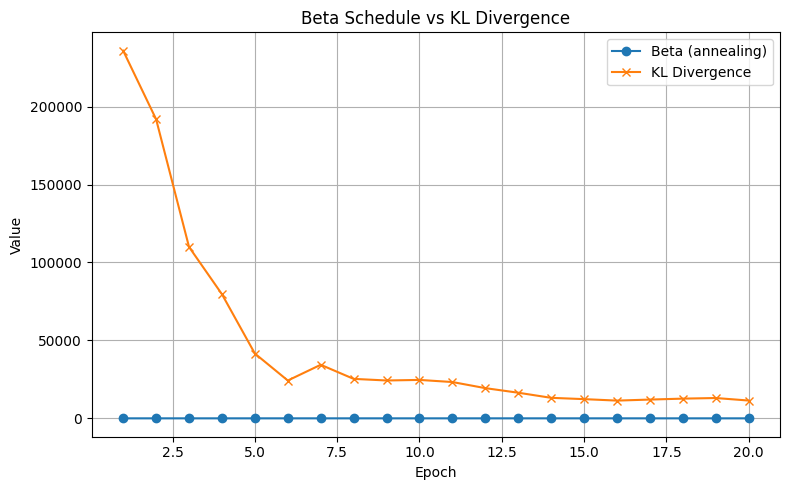

In [3]:
# save results
save_training_results({
    "train_losses": training_losses,
    "valid_losses": validation_losses,
    "recon_losses": recon_losses,
    "KL_losses": kl_losses,
    "beta_values": beta_values,
    "num_epochs": len(training_losses),
    "avg_epoch_time": total_epoch_time / len(training_losses),
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "warmup_epochs": warmup_epochs,
    "shape": shape,
    "baseline": baseline,
    "disable": disable,
    "cyclical": cyclical,
}, "vae.json")

# plot loss curves
epochs = range(1, len(training_losses)+1)
plt.figure(figsize=(8,5))
plt.plot(epochs, training_losses, label='Train Loss', marker='o')
plt.plot(epochs, validation_losses, label='Val Loss', marker='x')
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# plot recon vs KL
plt.figure(figsize=(8,5))
plt.plot(epochs, recon_losses, label='Reconstruction', marker='o')
plt.plot(epochs, kl_losses,    label='KL Divergence', marker='x')
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Recon vs KL Loss")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

if not disable:
    # plot beta vs KL
    plt.figure(figsize=(8,5))
    plt.plot(epochs, beta_values, label='Beta (annealing)', marker='o')
    plt.plot(epochs, kl_losses,   label='KL Divergence', marker='x')
    plt.xlabel("Epoch"); plt.ylabel("Value")
    plt.title("Beta Schedule vs KL Divergence")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()


## Sampling from the VAE: Audio Generation

We sample from the **latent space** and decode the samples to reconstruct audio signals.

### Steps:

1. **Set model to evaluation mode**:
   Ensures dropout and batch norm (if any) behave deterministically.

2. **Sample latent vectors**:
   $$ Z \sim \mathcal{N}(0, I) $$
   We draw `num_samples` latent vectors from a standard Gaussian.

3. **Decode latent vectors**:
   The decoder produces a tensor of shape:
   $$
   \text{decoded} \in \mathbb{R}^{B \times 2 \times H \times W}
   $$
   where:
   - Channel 0: **magnitude**
   - Channel 1: **phase**

4. **Reconstruct complex STFT**:
   $$
   \hat{X} = \text{magnitude} \cdot e^{i \cdot \text{phase}}
   $$

5. **Apply inverse STFT** to obtain the waveform in the time domain:
   $$
   \hat{x}(t) = \text{ISTFT}(\hat{X})
   $$

6. **Listen to generated audio samples**:
   Each waveform is rendered using `IPython.display.Audio`.

In [4]:
model.eval()

num_samples = 10
    
# Sample latents
Z = torch.randn(num_samples, latent_dim, device=device)

with torch.no_grad():
    # Decode latent vectors
    decoded = model.decoder(Z)  # (B, 2, H', W')
    decoded = adjust_shape(decoded, (input_height, input_width), pad_mode='reflect') # (B, 2, H, W)

    # Separate magnitude and phase
    mag   = decoded[:, 0, :, :]         # (B, H, W)
    phase = decoded[:, 1, :, :]         # (B, H, W)

    # Reconstruct complex STFT
    complex_stft = mag * torch.exp(1j * phase)  # (B, H, W)

    # Inverse STFT to waveform
    reconstructed = istft_transform(complex_stft)  # (B, T)

# Play audios
for i in range(num_samples):
    print(f"\n=== Generated Sample {i+1} ===")
    waveform = reconstructed[i].squeeze().cpu().numpy()
    display(Audio(waveform, rate=sample_rate))


=== Generated Sample 1 ===



=== Generated Sample 2 ===



=== Generated Sample 3 ===



=== Generated Sample 4 ===



=== Generated Sample 5 ===



=== Generated Sample 6 ===



=== Generated Sample 7 ===



=== Generated Sample 8 ===



=== Generated Sample 9 ===



=== Generated Sample 10 ===


# Plotting the latent space

Does the VAE learn a latent representation that groups together similar-sounding instruments?

Principal Component Analysis (PCA) is a way to take high-dimensional data and find a new set of orthogonal axes (directions) that capture as much of its variability as possible, in descending order.

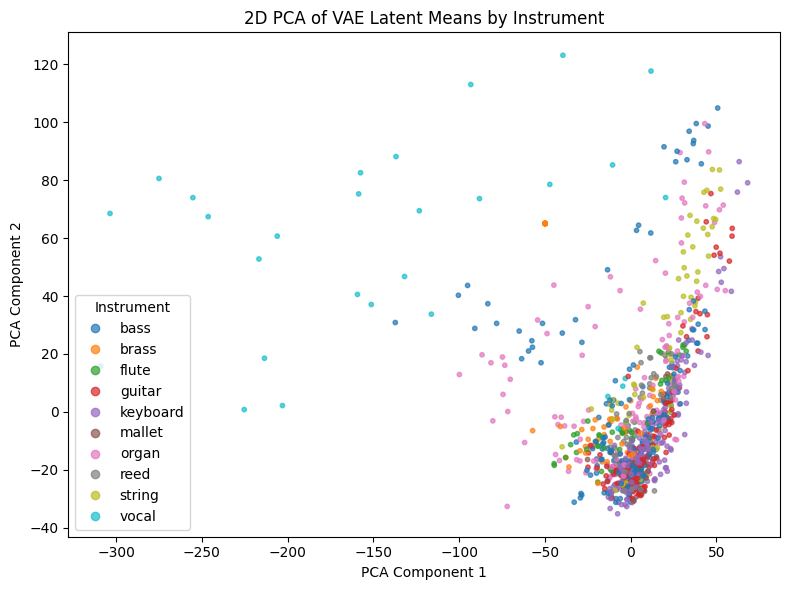

In [5]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from src.dataset import NSynth
from src.models import VAE
from src.utils.models import compute_magnitude_and_phase, adjust_shape
from src.utils.dataset import INSTRUMENT_ID_2_STR
import torchaudio.transforms as T

model = VAE((input_height, input_width), latent_dim=latent_dim, channels=channels).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Dataset + loader
dataset = NSynth(partition='testing')
loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many points to plot
N = 1000
mus    = []
labels = []

with torch.no_grad():
    for waveform, _, _, metadata in loader:
        B = waveform.size(0)
        waveform = waveform.to(device)  
        S = stft_transform(waveform)                    # [B,1,F,T]
        mag, ph = compute_magnitude_and_phase(S)        # each [B,1,F,T]
        x = torch.cat([mag, ph], dim=1)                 # [B,2,F,T]

        # encoder returns (feat, mu, logvar)
        _, mu, _ = model.encoder(x)
        mus.append(mu.cpu().numpy())

        # convert one‐hot instrument to string
        oh = metadata['one_hot_instrument']
        for v in oh:
            labels.append(INSTRUMENT_ID_2_STR[int(v.argmax())])

        if len(labels) >= N:
            break

mus    = np.vstack(mus)[:N]      # shape (N, latent_dim)
labels = np.array(labels[:N])    # shape (N,)

# Map each unique string label to an integer color code
unique_instr   = np.unique(labels)
instr2code     = {instr: i for i, instr in enumerate(unique_instr)}
color_codes    = np.array([instr2code[l] for l in labels])  # shape (N,)

# PCA down to 2D
pca = PCA(n_components=2)
z2  = pca.fit_transform(mus)  # shape (N,2)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    z2[:,0], z2[:,1],
    c=color_codes,
    cmap='tab10',
    s=10,
    alpha=0.7
)

# Build legend
handles, _ = scatter.legend_elements(num=len(unique_instr))
plt.legend(handles, unique_instr, title="Instrument", loc='best')

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA of VAE Latent Means by Instrument")
plt.tight_layout()
plt.show()